Gaussian Mixture model
-----

In [2]:
import numpy as np
import pylab as plt
%matplotlib inline

Generate some data with three clear clusters

In [3]:
cluster_means = [[0,0],[4,4],[-4,4]]
n_data = 20 # Number in each cluster
x = np.empty(shape=(0,2))
for i,m in enumerate(cluster_means):
    x = np.vstack((x,np.random.randn(n_data,2) + np.tile(m,(n_data,1))))

Plot the data

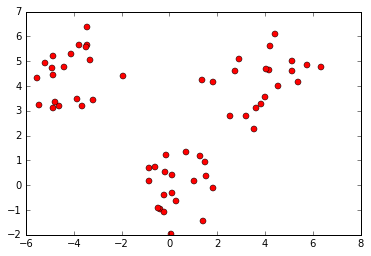

In [4]:
plt.figure()
plt.plot(x[:,0],x[:,1],'ro')

We will use a Gaussian mixture with *isotropic* covariance -- i.e., the covariance matrices will have no off-diagonal terms (the Gaussians are all circles and ellipses aligned with the axes)

Firstly, define a function for plotting contours etc -- this will be useful

In [154]:
def mix_plot(data,mixpars):
    col = ['r','g','b']
    plt.figure()
    plt.scatter(data[:,0],data[:,1],c=mixpars['Z'])
    xvals = np.arange(data[:,0].min()-0.1,data[:,0].max()+0.1,0.2)[:,None]
    yvals = np.arange(data[:,1].min()-0.1,data[:,1].max()+0.1,0.2)[:,None]
    X,Y = np.meshgrid(xvals,yvals)
    K = len(mix_pars['mu'])
    for k in range(K):
        like = np.zeros_like(X)
        xlike = 1.0/(np.sqrt(2.0*np.pi*mixpars['ss'][k,0]))
        xlike*=np.exp((-1.0/(2.0*mixpars['ss'][k,0]))*(X-mixpars['mu'][k,0])**2)
        ylike = 1.0/(np.sqrt(2.0*np.pi*mixpars['ss'][k,1]))
        ylike*=np.exp((-1.0/(2.0*mixpars['ss'][k,1]))*(Y-mixpars['mu'][k,1])**2)
        like = mixpars['pi'][k]*xlike*ylike
        plt.contour(X,Y,like,colors = col[k])
        

Initialise the cluster parameters and run the E-M algorithm

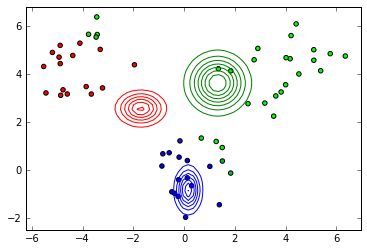

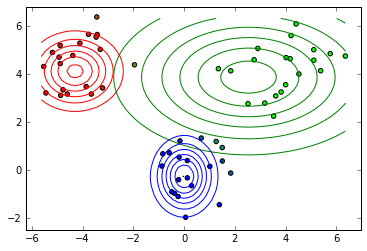

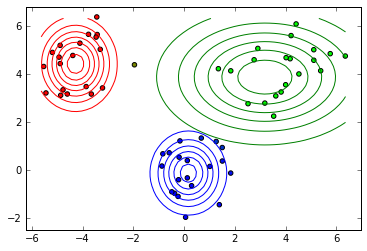

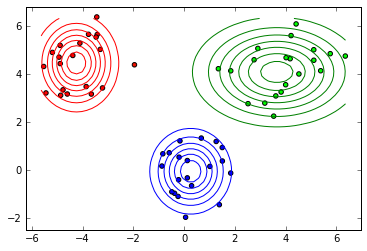

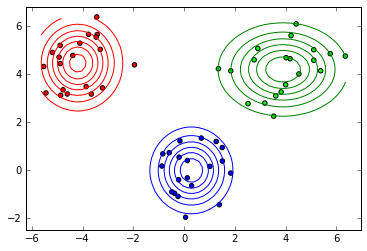

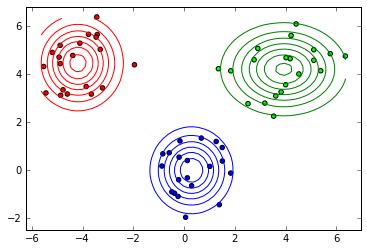

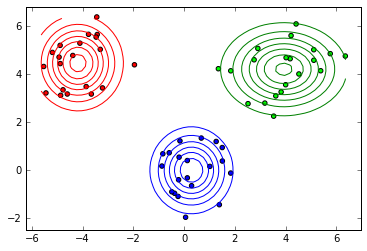

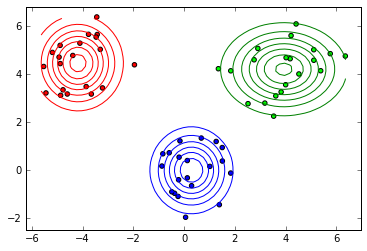

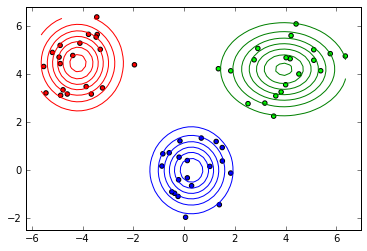

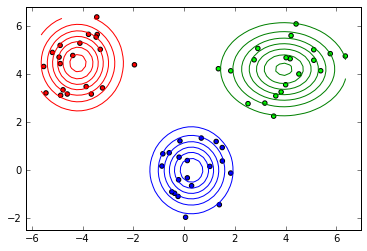

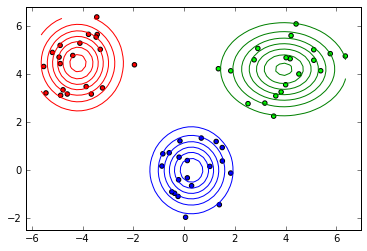

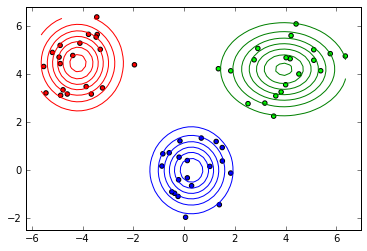

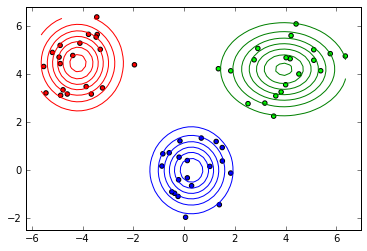

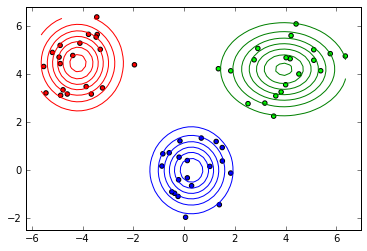

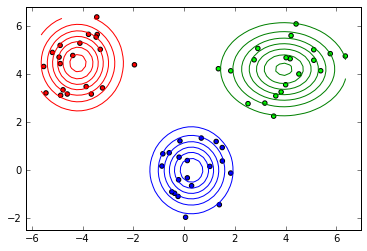

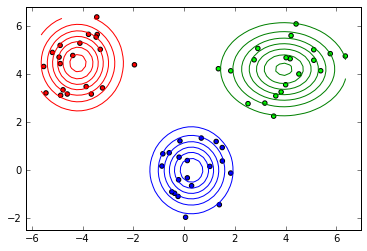

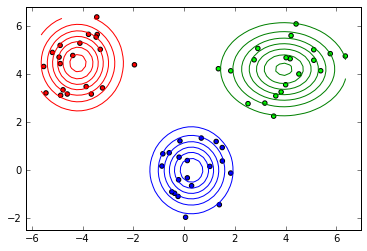

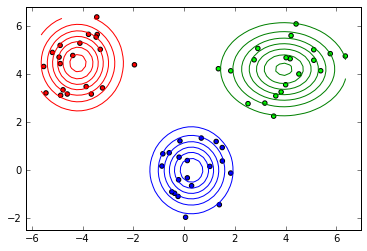

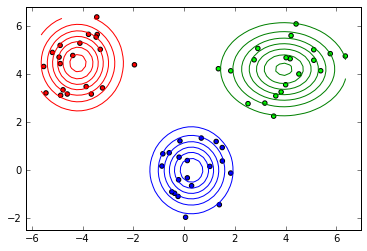

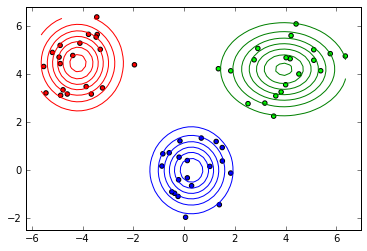

In [155]:
mix_pars = {}
mix_pars['mu'] = np.random.rand(K,2)*10 - 5
mix_pars['ss'] = np.random.rand(K,2)
Z = np.random.rand(N,K)
Z /= (Z.sum(axis=1))[:,None]
mix_pars['Z'] = Z
mix_pars['pi'] = (1.0/3.0)*np.ones(K)


# Run the algorithm

max_its = 20
for it in range(max_its):
    # Update z
    # Note that this is slooooow - could be written better
    for n in range(N):
        for k in range(K):
            # Compute the pdf - do it in log space for stability
            mix_pars['Z'][n,k] = 0.0
            for d in range(2): # loop over dimensions
                mix_pars['Z'][n,k] += -0.5*np.log(2.0*np.pi*mix_pars['ss'][k,d])
                mix_pars['Z'][n,k] += -0.5*(1.0/mix_pars['ss'][k,d])*(x[n,d]-mix_pars['mu'][k,d])**2
            mix_pars['Z'][n,k] += np.log(mix_pars['pi'][k])
        ma = mix_pars['Z'][n,:].max()
        mix_pars['Z'][n,:] = np.exp(mix_pars['Z'][n,:] - ma)
        mix_pars['Z'][n,:] /= mix_pars['Z'][n,:].sum()
            
    mix_plot(x,mix_pars)
    # Update mu
    for k in range(K):
        mix_pars['mu'][k,:] = (x*mix_pars['Z'][:,k][:,None]).sum(axis=0)/mix_pars['Z'][:,k].sum()
    
    # Update ss
    for k in range(K):
        mix_pars['ss'][k,:] = (((x - mix_pars['mu'][k,:])**2)*mix_pars['Z'][:,k][:,None]).sum(axis=0)/mix_pars['Z'][:,k].sum()
        for d in range(2):
            if mix_pars['ss'][k,d] < 1e-4:
                mix_pars['ss'][k,d] = 1e-4 # minimum variance allowed - stops gaussians shrinking down onto one data point
    
    # Update Pi
    mix_pars['pi'] = mix_pars['Z'].sum(axis=0) + 0.00001*np.ones(K)
    mix_pars['pi'] /= mix_pars['pi'].sum()
    